# A/B Test로 고객 retention을 높이자
모바일 게임의 고객 로그 데이터를 분석해서 고객 유지율을 높여봅니다.

## 데이터 설명
데이터는 [다음의 링크](https://drive.google.com/file/d/1CDAcyNkWYfLbQokwyLrNR8e1AxlXBGi7/view?usp=sharing)에서 다운받을 수 있습니다. 
(https://www.kaggle.com/yufengsui/mobile-games-ab-testing)

  * **userid** - 개별 유저들을 구분하는 식별 번호입니다. 
  * **version** - 유저들이 실험군 대조군 중 어디에 속했는지 알 수 있습니다. (gate_30, gate_40) 
  * **sum_gamerounds** - 첫 설치 후 14일 간 유저가 플레이한 라운드의 수입니다. 
  * **retention_1** - 유저가 설치 후 1일 이내에 다시 돌아왔는지 여부입니다.
  * **retention_7** - 유저가 설치 후 7일 이내에 다시 돌아왔는지 여부입니다. 
  * 게임 플레이 영상 참고 (https://www.youtube.com/watch?v=xt_5OtfXl7o)

## 문제 정의 
  * Cookie Cats 게임에서는 특정 스테이지가 되면 스테이지가 Lock되게 합니다. 
  * Area Locked일 경우 Keys를 구하기 위한 특별판 게임을 해서 키 3개를 구하거나, 페이스북 친구에게 요청하거나, 유료아이템을 구매하여 바로 열 수 있습니다. 
  ![Area Locked](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png)
  * Lock을 몇 번째 스테이지에서 할 때 이용자 retention에 가장 좋을지 의사결정을 해야합니다. 

### 데이터 탐색

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# 데이터를 불러옵니다.
df = pd.read_csv('../data/cookie_cats.csv')

In [10]:
df.shape

(90189, 5)

In [7]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [6]:
# 결측값이 있는지 확인합니다. 
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

다행히(?) 결측값은 없는 것으로 보입니다. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [11]:
# AB 테스트로 사용된 버전별로 유저들은 몇 명씩 있을까요?
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

유저가 게임을 설치하면 gate_30 또는 gate_40 그룹으로 나뉘게 되었는데, 각 그룹별 유저는 거의 유사한 숫자로 배정되었습니다. 

<AxesSubplot:ylabel='sum_gamerounds'>

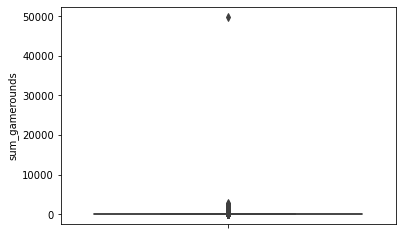

In [12]:
# box plot을 그려봅니다. 
sns.boxplot(data=df, y= "sum_gamerounds")

* 확실히 아웃라이어가 있는 것으로 보입니다. 
* 첫 14일 동안 50,000회 가까이 게임을 한 사람들이 분명히 있지만 일반적인 사용행태라고 하기는 어렵습니다. 
* 엄청나게 skewed한 데이터 분포입니다. 


In [13]:
df[df['sum_gamerounds'] > 45000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [15]:
# 45000 이상 플레이한 유저를 제거합니다. 
df = df[df['sum_gamerounds'] < 45000]

In [16]:
df.shape

(90188, 5)

In [17]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [24]:
# percentile을 살펴봅니다. 
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

* 상위 50%의 유저들은 첫 14일 동안 게임을 16회 했습니다. 


### 데이터 분석

In [26]:
# 각 게임실행횟수 별 유저의 수를 카운트 해봅니다. 
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

Text(0.5, 0, '# Game rounds')

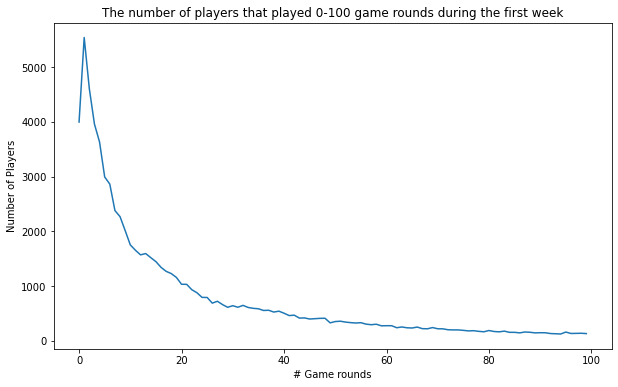

In [27]:
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sum_gamerounds', ylabel='Density'>

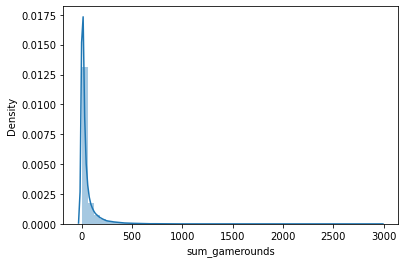

In [28]:
sns.distplot(df['sum_gamerounds'])

* 게임을 설치하고 한 번도 실행하지 않은 유저들의 수가 상당하다는 것을 알 수 있습니다. 
* 몇몇 유저들은 설치 첫주에 충분히 실행을 해보고 게임에 어느정도 중독(?) 되었다는 것을 알 수 있습니다. 
* 비디오 게임산업에서 **1-day retention**은 게임이 얼마나 재미있고 중독적인지 평가하는 주요 메트릭입니다. 
* **1-day retention**이 높을 경우 손쉽게 가입자 기반을 늘려갈 수 있습니다. 

In [31]:
# 1-day retention의 평균을 살펴봅니다. 
df['retention_1'].mean()

0.4452144409455803

* 절반에 못미치는 사용자들이 설치 다음날 다시 게임을 했다는 것을 알 수 있습니다. 

In [30]:
# 그룹별 1-day retention의 평균을 살펴봅니다. 
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

* 단순히 그룹간 평균을 비교해봐서는 게이트가 40(44.2%)인 것보다 30(44.8%)인 경우에 플레이 횟수가 더 많습니다. 
* 작은 차이이지만 이 작은 차이가 retention, 더 나아가 장기적 수익에도 영향을 미치게 될 것입니다. 
* 그런데 이것만으로 게이트를 30에 두는 것이 40에 두는 것보다 나은 방법이라고 확신할 수 있을까요 ?

In [33]:
# 7-day retention의 평균을 살펴봅니다. 
df['retention_7'].mean()

0.1860557945624695

In [34]:
# 그룹별 7-day retention의 평균을 살펴봅니다. 
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

* 단순히 그룹간 평균을 비교해봐서는 게이트가 40(18.2%)인 것보다 30(19.0%)인 경우에 생존률이 더 높습니다.  
* 작은 차이이지만 이 작은 차이가 retention, 더 나아가 장기적 수익에도 영향을 미치게 될 것입니다. 
* 1일보다 7일일때 차이가 더 큽니다. 그런데 이것만으로 게이트를 30에 두는 것이 40에 두는 것보다 나은 방법이라고 확신할 수 있을까요 ?

#### Bootstrapping 
두 그룹간의 차이가 유의미한지 알아보는 다른 방법을 사용해보겠습니다. 

<AxesSubplot:ylabel='Density'>

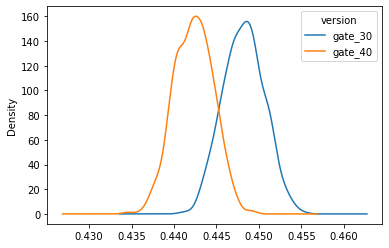

In [35]:
# 각각의 AB그룹에 대해 bootstrapp된 means 값의 리스트를 만듭니다.

boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# list를 DataFrame으로 변환합니다. 
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

* 위의 두 분포는 AB 두 그룹에 대해 1 day retention이 가질 수 있는 부트 스트랩 불확실성을 표현합니다. 
* 비록 작지만 차이의 증거가있는 것 같아 보입니다. 
* 자세히 살펴보기 위해 % 차이를 그려 봅시다.

게이트가 레벨30에 있을 때 1-day retention이 클 확률: 0.96


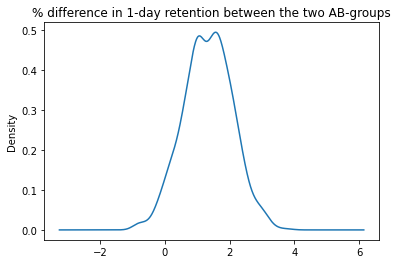

In [36]:
# 두 AB 그룹간의 % 차이 평균 컬럼을 추가합니다.
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# bootstrap % 차이를 시각화 합니다. 
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# 게이트가 레벨30에 있을 때 1-day retention이 클 확률을 계산합니다. 
print('게이트가 레벨30에 있을 때 1-day retention이 클 확률:',(boot_1d['diff'] > 0).mean())

* 위 도표에서 가장 가능성이 높은 % 차이는 약 1%-2%이며 분포의 95%는 0% 이상이며 레벨 30의 게이트를 선호합니다.

* 부트 스트랩 분석에 따르면 게이트가 레벨 30에있을 때 1일 유지율이 더 높을 가능성이 높습니다. 
* 그러나 플레이어는 하루 동안 만 게임을했기 때문에 대부분의 플레이어가 아직 레벨 30에 다다르지 않았을 가능성이 큽니다. 
* 즉, 대부분의 유저들은 게이트가 30에 있는지 여부에 따라 retention이 영향받지 않았을 것입니다. 
* 일주일 동안 플레이 한 후에는 더 많은 플레이어가 레벨 30과 40에 도달하기 때문에 7 일 retention도 확인해야합니다.

In [41]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

* 1일 retention과 마찬가지로, 게이트가 30 레벨(19.0 %)에 있는 경우보다 게이트 레벨이 40(18.2 %)인 경우 7일 retention이 낮습니다.
* 이 차이는 1 일 retention보다 차이가 더 큰데, 아마도 더 많은 플레이어가 첫 번째 게이트를 열어볼 시간이 있었기 때문일 것입니다.
* 전체 7일 retention은 전체 1일 retention보다 낮습니다. 설치 후 하루보다 설치 후 일주일에 게임을하는 사람이 더 적기 때문입니다.
* 이전과 마찬가지로 부트 스트랩 분석을 사용하여 AB 그룹간에 차이가 있는지 확인해봅시다.

게이트가 레벨30에 있을 때 7-day retention이 클 확률: 0.996


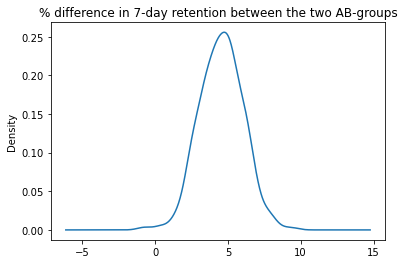

In [42]:
# 각각의 AB그룹에 대해 bootstrapp된 means 값의 리스트를 만듭니다.
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# list를 DataFrame으로 변환합니다. 
boot_7d = pd.DataFrame(boot_7d)

# 두 AB 그룹간의 % 차이 평균 컬럼을 추가합니다.
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# bootstrap % 차이를 시각화 합니다.
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# 게이트가 레벨30에 있을 때 7-day retention이 더 클 확률을 계산합니다. 
print('게이트가 레벨30에 있을 때 7-day retention이 클 확률:',(boot_7d['diff'] > 0).mean())

* 부트 스트랩 결과는 게이트가 레벨 40에있을 때보 다 레벨 30에있을 때 7일 retention이 더 높다는 강력한 증거가 있음을 나타냅니다. 
* 결론은, retention을 늘리기 위해서 게이트를 레벨 30에서 레벨 40으로 이동해서는 안된다는 것 입니다! 

#### T-test
통계적인 기준으로 판단하는 방법을 알아봅니다. 

In [43]:
df_30 = df[df['version'] == 'gate_30']
print(df_30.shape)
df_30.tail()

(44699, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90179,9998576,gate_30,14,True,False
90180,9998623,gate_30,7,False,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False
90186,9999710,gate_30,28,True,False


In [44]:
df_40 = df[df['version'] == 'gate_40']
print(df_40.shape)
df_40.tail()

(45489, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90181,9998733,gate_40,10,True,False
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


* 단순히 그룹간 평균을 비교해봐서는 게이트가 40(44.2%)인 것보다 30(44.8%)인 경우에 플레이 횟수가 더 많습니다. 
* 작은 차이이지만 이 작은 차이가 retention, 더 나아가 장기적 수익에도 영향을 미치게 될 것입니다. 
* 그런데 이것만으로 게이트를 30에 두는 것이 40에 두는 것보다 나은 방법이라고 확신할 수 있을까요 ?

In [45]:
from scipy import stats
#독립표본 T-검정 (2 Sample T-Test)

tTestResult = stats.ttest_ind(df_30['retention_1'], df_40['retention_1'])

tTestResultDiffVar = stats.ttest_ind(df_30['retention_1'], df_40['retention_1'], equal_var=False)

tTestResult

Ttest_indResult(statistic=1.7871153372992439, pvalue=0.07392220630182521)

In [46]:
tTestResult = stats.ttest_ind(df_30['retention_7'], df_40['retention_1'])
tTestResultDiffVar = stats.ttest_ind(df_30['retention_7'], df_40['retention_1'], equal_var=False)

tTestResult

Ttest_indResult(statistic=-84.48321935747556, pvalue=0.0)

##### T Score
- t-score가 크면 두 그룹이 다르다는 것을 의미합니다. 
- t-score가 작으면 두 그룹이 비슷하다는 것을 의미합니다. 

##### P-values
- p-value는 5%수준에서 0.05입니다. 
- p-values는 작은 것이 좋습니다. 이것은 데이터가 우연히 발생한 것이 아니라는 것을 의미합니다. 
- 예를 들어 p-value가 0.01 이라는 것은 결과가 우연히 나올 확률이 1%에 불과하다는 것을 의미합니다. 
- 대부분의 경우 0.05 (5%) 수준의 p-value를 기준으로 삼습니다. 이 경우 통계적으로 유의하다고 합니다. 

[T-test 참고링크](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/t-test/)

* 위 분석결과를 보면, 두 그룹에서 retention_1에 있어서는 유의하지 않고, retention_7에서는 유의미한 차이가 있다는 것을 알 수 있습니다. 
* 다시말해, retention_7이 gate30이 gate40 보다 높은 것은 우연히 발생한 일이 아닙니다.
* 즉, gate는 30에 있는 것이 40에 있는 것보다 retention 7 차원에서 더 좋은 선택지 입니다.  

#### chi-square
* 사실 t-test는 retention 여부를 0,1 로 두고 분석한 것입니다.

* 하지만 실제로 retention 여부는 범주형 변수입니다. 
이 방법보다는 chi-square검정을 하는 것이 더 좋은 방법입니다. 

* 카이제곱검정은 어떤 범주형 확률변수  𝑋 가 다른 범주형 확률변수  𝑌 와 독립인지 상관관계를 가지는가를 검증하는데도 사용됩니다. 
* 카이제곱검정을 독립을 확인하는데 사용하면 카이제곱 독립검정이라고 부릅니다. 

* 만약 두 확률변수가 독립이라면  𝑋=0 일 때의  𝑌 분포와  𝑋=1 일 때의  𝑌 분포가 같아야 합니다. 
* 다시말해 버전이 30일때와 40일 때 모두 Y의 분포가 같은 것입니다. 
* 따라서 표본 집합이 같은 확률분포에서 나왔다는 것을 귀무가설로 하는 카이제곱검정을 하여 채택된다면 두 확률변수는 독립입니다. 
* 만약 기각된다면 두 확률변수는 상관관계가 있는 것입니다.
* 다시말해 카이제곱검정 결과가 기각된다면 게이트가 30인지 40인지 여부에 따라 retention의 값이 변화하게 된다는 것입니다. 

* 𝑋 의 값에 따른 각각의  𝑌 분포가 2차원 표(contingency table)의 형태로 주어지면 독립인 경우의 분포와 실제 y 표본본포의 차이를 검정통계량으로 계산합니다. 
* 이 값이 충분히 크다면  𝑋 와  𝑌 는 상관관계가 있다. 

In [47]:
# 분할표를 만들기 위해 버전별로 생존자의 수 합계를 구합니다. 
df.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222937707836,2294941,20034,8501
gate_40,227857702576,2333530,20119,8279


In [48]:
#버전별 전체 유저의 수를 구합니다. 
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44699,44699,44699,44699
gate_40,45489,45489,45489,45489


### 버전 별 분할표를 만들어봅니다. 
||retention_1=False|retention_1=True|
|------|---|---|
|version=gate30|(44699-20034)|20034|
| version=gate40|(45489-20119)|20119|



||retention_7=False|retention_7=True|
|------|---|---|
|version=gate30|(44699-8501)|8501|
| version=gate40|(45489-8279)|8279|



In [49]:
import scipy as sp
obs1 = np.array([[20119, (45489-20119)], [20034, (44699-20034)]])
sp.stats.chi2_contingency(obs1)

(3.1698355431707994,
 0.07500999897705699,
 1,
 array([[20252.35970417, 25236.64029583],
        [19900.64029583, 24798.35970417]]))

* 카이제곱 독립검정의 유의확률은 7.5%입니다. 
* 즉  𝑋 와  𝑌 는 상관관계가 있다고 말할 수 없습니다.

In [50]:
obs2 = np.array([[8501, (44699-8501)], [8279, (45489-8279)]])
sp.stats.chi2_contingency(obs2)

(9.915275528905669,
 0.0016391259678654423,
 1,
 array([[ 8316.50796115, 36382.49203885],
        [ 8463.49203885, 37025.50796115]]))

* 카이제곱 독립검정의 유의확률은 0.1%입니다. 
* 즉  𝑋 와  𝑌 는 상관관계가 있다고 말할 수 있습니다.
* 게이트가 30에 있는지 40에 있는지 여부에 따라 7일 뒤 retention이 상관관계가 있는 것입니다. 
* 7일 뒤 retention 유지를 위하여 게이트는 30에 유지해야 합니다. 



### 결론
gate는 30에 유지해야합니다. 

### 더 생각해 볼 것 
* 실제로는 retention 이외에 함께 고려해야 할 다양한 메트릭들이 있습니다. 
* 앱내 구매, 게임 플레이 횟수, 친구초대로 인한 referrer 등 입니다. 
* 본 데이터에서는 retention만 주어져 있기에 한 가지를 주안점을 두어 분석 했습니다. 
* 서비스 운영자, 기획자 차원에서 정말 중요한 메트릭을 정하고 그 것을 기준으로 테스트 결과를 평가하는 것이 중요합니다. 
